In [2]:
from credit_approval.data.retrieval import get_data
from credit_approval.data.retrieval import get_data_info

In [3]:
info = get_data_info()
target = info[info["role"]=="Target"]["name"].values[0]

df = get_data()

In [ ]:
info

,name,role,type,demographic,description,units,missing_values
0,A16,Target,Categorical,None,None,None,no
1,A15,Feature,Continuous,None,None,None,no
2,A14,Feature,Continuous,None,None,None,yes
3,A13,Feature,Categorical,None,None,None,no
4,A12,Feature,Categorical,None,None,None,no
5,A11,Feature,Continuous,None,None,None,no
6,A10,Feature,Categorical,None,None,None,no
7,A9,Feature,Categorical,None,None,None,no
8,A8,Feature,Continuous,None,None,None,no
9,A7,Feature,Categorical,None,None,None,yes


In [14]:
categorical_columns = list(info[(info["type"]=="Categorical") & (info["name"] != target)]["name"].values)
numerical_columns = list(info[info["type"]=="Continuous"]["name"].values)  

In [23]:
print("Categorical columns: ", categorical_columns)

Categorical columns:  ['A13', 'A12', 'A10', 'A9', 'A7', 'A6', 'A5', 'A4', 'A1']


In [24]:
print("Numerical columns: ", numerical_columns) 

Numerical columns:  ['A15', 'A14', 'A11', 'A8', 'A3', 'A2']


In [25]:
print(df[categorical_columns].head())

  A13 A12 A10 A9 A7 A6 A5 A4 A1
0   g   f   t  t  v  w  g  u  b
1   g   f   t  t  h  q  g  u  a
2   g   f   f  t  h  q  g  u  a
3   g   t   t  t  v  w  g  u  b
4   s   f   f  t  v  w  g  u  b


In [26]:
print(df[numerical_columns].head())

   A15    A14  A11    A8     A3     A2
0    0  202.0    1  1.25  0.000  30.83
1  560   43.0    6  3.04  4.460  58.67
2  824  280.0    0  1.50  0.500  24.50
3    3  100.0    5  3.75  1.540  27.83
4    0  120.0    0  1.71  5.625  20.17


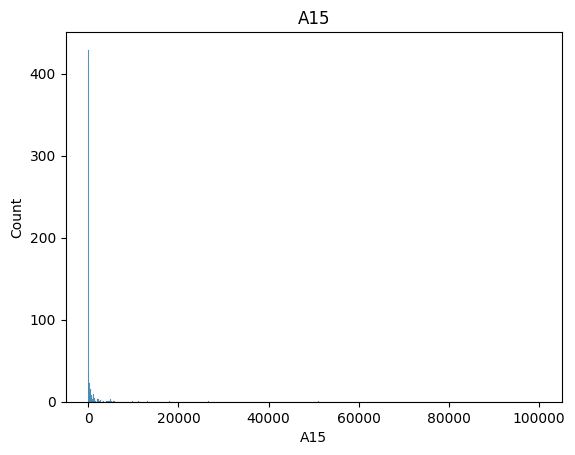

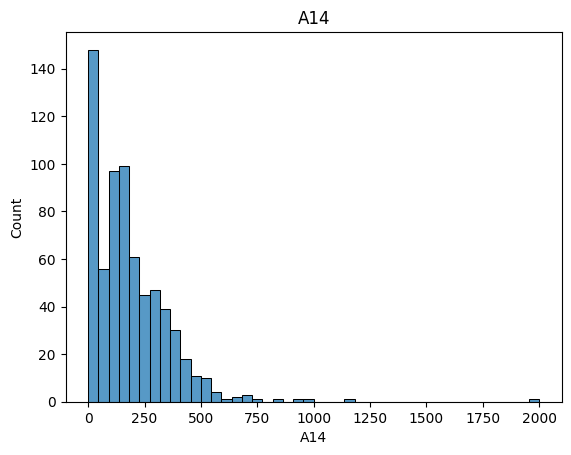

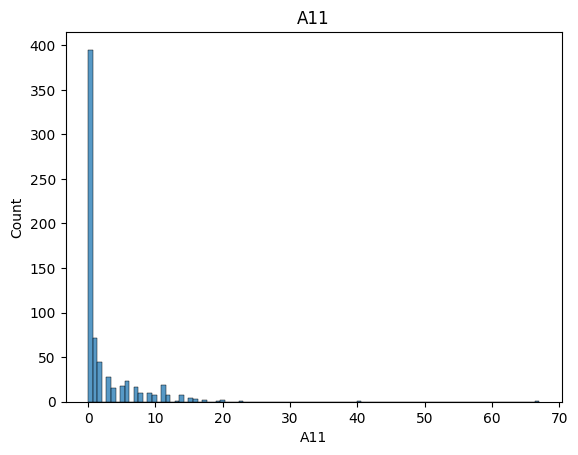

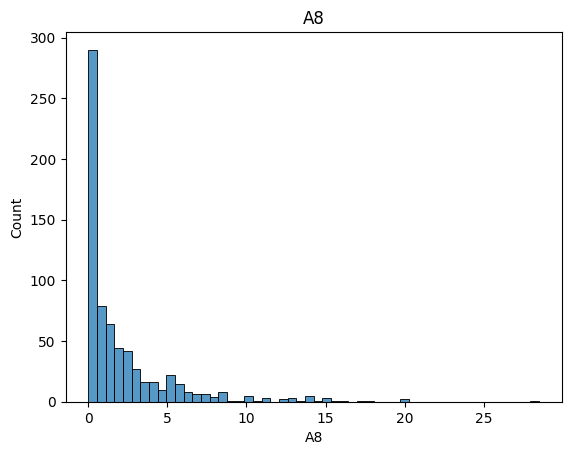

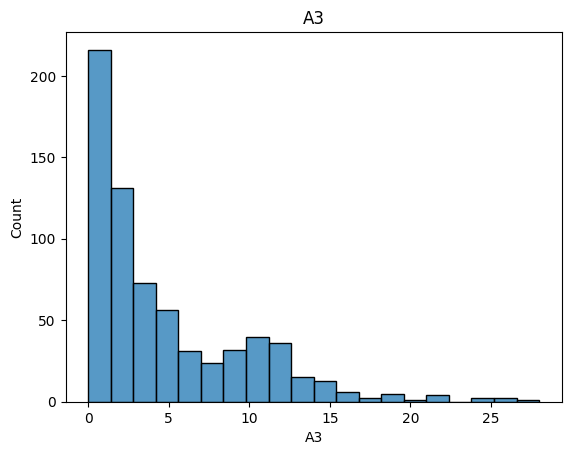

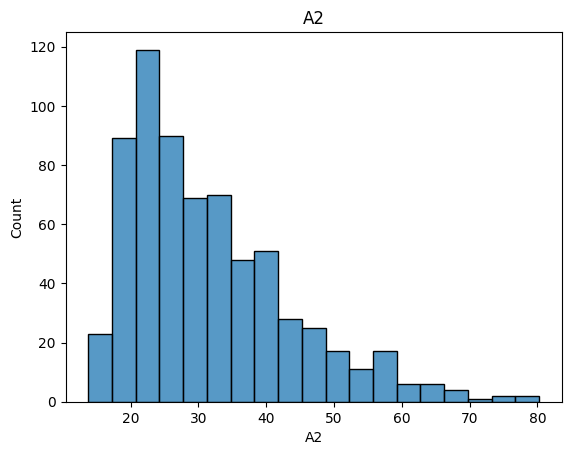

In [27]:
# get some plots of numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

for col in numerical_columns:
    sns.histplot(df[col])
    plt.title(col)
    plt.show()

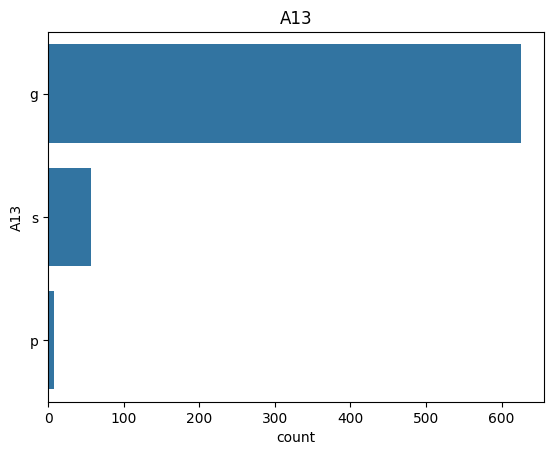

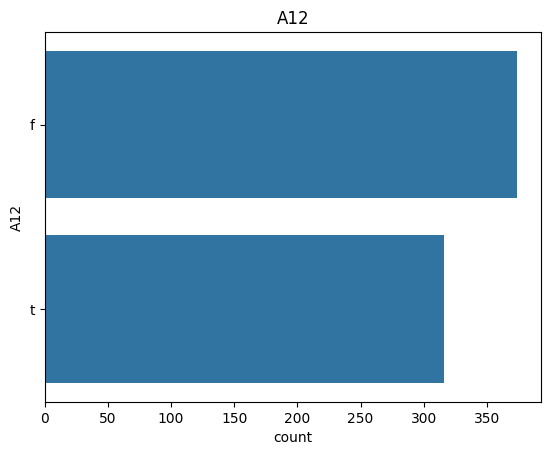

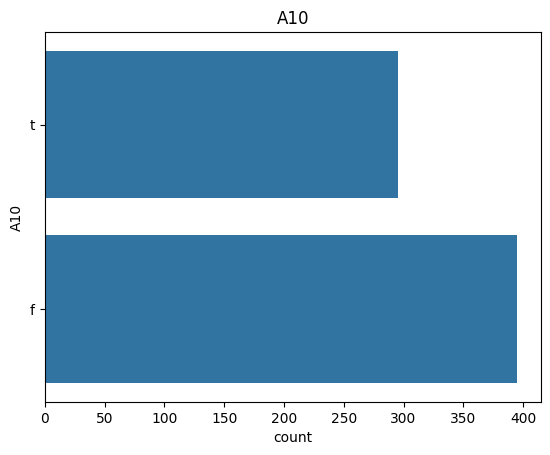

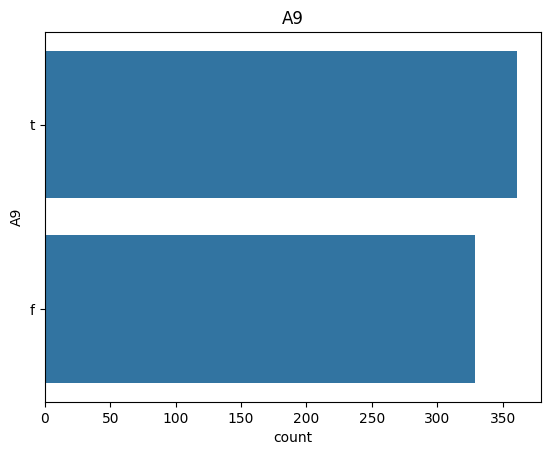

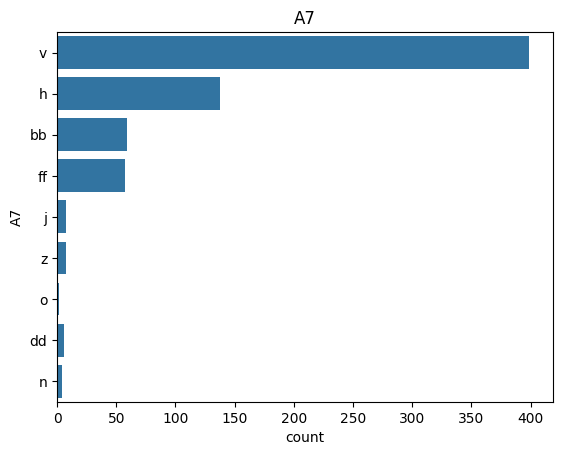

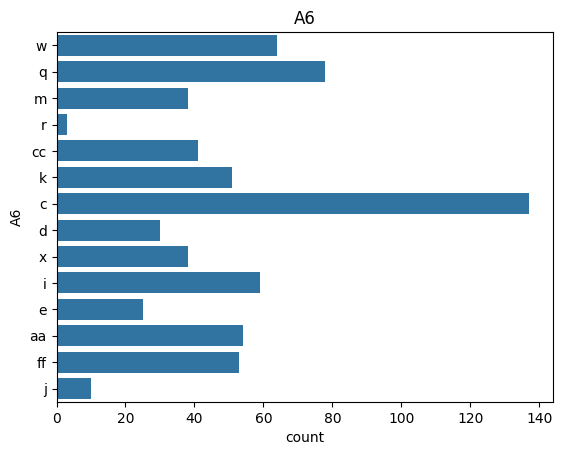

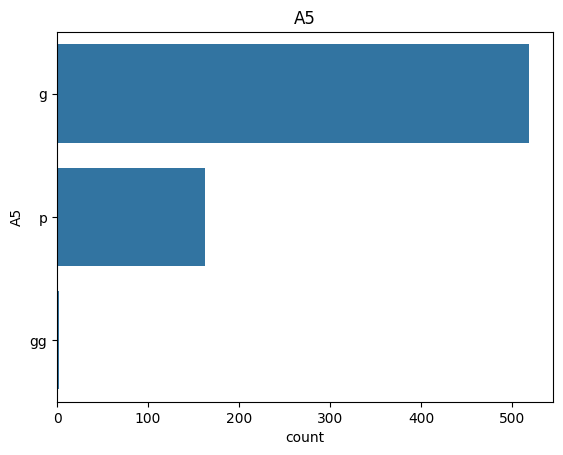

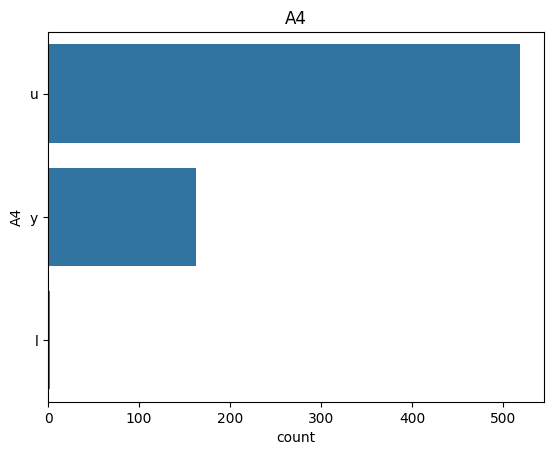

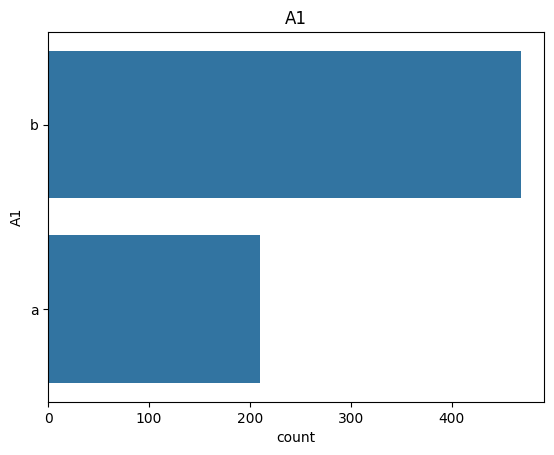

In [28]:
# get some plots for categorical columns

for col in categorical_columns:
    sns.countplot(df[col])
    plt.title(col)
    plt.show()
    

In [29]:
from credit_approval.model.pipelines import get_sk_pipeline
from credit_approval.data.featurization import get_train_test_sets

In [35]:
pipeline = get_sk_pipeline(categorical_columns=categorical_columns, numerical_columns=numerical_columns)

In [36]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['A15', 'A14', 'A11', 'A8',
                                                   'A3', 'A2']),
                                                 ('encoder', OneHotEncoder(),
                                                  ['A13', 'A12', 'A10', 'A9',
                                                   'A7', 'A6', 'A5', 'A4',
                                                   'A1'])])),
                ('model', RandomForestClassifier())])

In [37]:
x_train, x_test, y_train, y_test = get_train_test_sets(target= target, test_size=0.2)
import pandas as pd

In [38]:
trained_pipeline = pipeline.fit(x_train,y_train)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from typing import List


In [40]:
categorical_imputer = ColumnTransformer(
    transformers=[
        (
            "categorical_imputer",
            SimpleImputer(strategy="most_frequent").set_output(transform="pandas"),
            categorical_columns,
        )
    ]
)

preprocessing = ColumnTransformer(
    transformers=[
        ("numerical_imputer", SimpleImputer(strategy="median"), numerical_columns),
        ("encoder", OneHotEncoder(), categorical_columns),
    ]
)

pipeline = Pipeline(
    steps=[
        # ("categorical_imputer", categorical_imputer),
        ("preprocessing", preprocessing),
        ("model", RandomForestClassifier()),
    ]
)

In [41]:
from skdag import DAGBuilder

dag = (
   DAGBuilder(infer_dataframe=True)
   .add_step("input", "passthrough")
   .add_step("categorical_imputer", SimpleImputer(strategy="most_frequent"),deps={"input":categorical_columns})
   .add_step("numerical_imputer", SimpleImputer(strategy="median"), deps={"input":numerical_columns}, dataframe_columns=numerical_columns)
   .add_step("encoder", OneHotEncoder(), deps={"categorical_imputer":categorical_columns}, dataframe_columns=categorical_columns)
   .add_step("model", RandomForestClassifier(), deps=["encoder","numerical_imputer"])
   .make_dag(n_jobs=2, verbose=True)
)


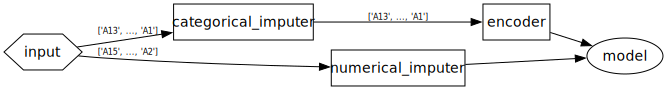

In [42]:
dag.show()

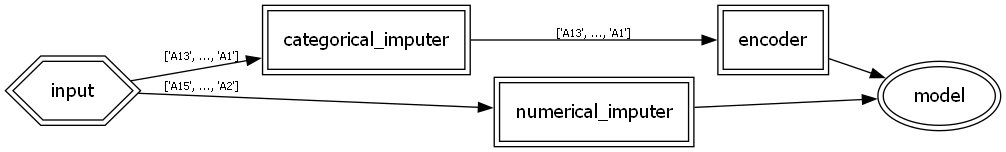

In [43]:
dag.fit({"input":x_train}, y_train)

In [44]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['A15', 'A14', 'A11', 'A8',
                                                   'A3', 'A2']),
                                                 ('encoder', OneHotEncoder(),
                                                  ['A13', 'A12', 'A10', 'A9',
                                                   'A7', 'A6', 'A5', 'A4',
                                                   'A1'])])),
                ('model', RandomForestClassifier())])

In [45]:
predictions = dag.predict({"input":x_test})
predictions2 = pipeline.predict(x_test)

In [46]:
from sklearn.metrics import classification_report
metrics = classification_report(y_test, predictions["model"], output_dict=True)
metrics2 = classification_report(y_test, predictions2, output_dict=True)

In [47]:

pd.DataFrame(metrics)

,0,1,accuracy,macro avg,weighted avg
precision,0.840580,0.855072,0.847826,0.847826,0.847931
recall,0.852941,0.842857,0.847826,0.847899,0.847826
f1-score,0.846715,0.848921,0.847826,0.847818,0.847834
support,68.000000,70.000000,0.847826,138.000000,138.000000


In [48]:
pd.DataFrame(metrics2)

,0,1,accuracy,macro avg,weighted avg
precision,0.816901,0.850746,0.833333,0.833824,0.834069
recall,0.852941,0.814286,0.833333,0.833613,0.833333
f1-score,0.834532,0.832117,0.833333,0.833325,0.833307
support,68.000000,70.000000,0.833333,138.000000,138.000000


In [50]:
from credit_approval.model.model_utils import get_performance_plots

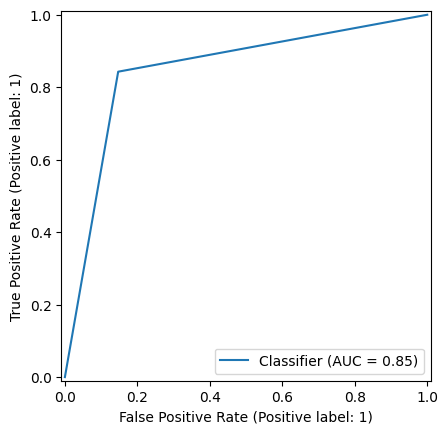

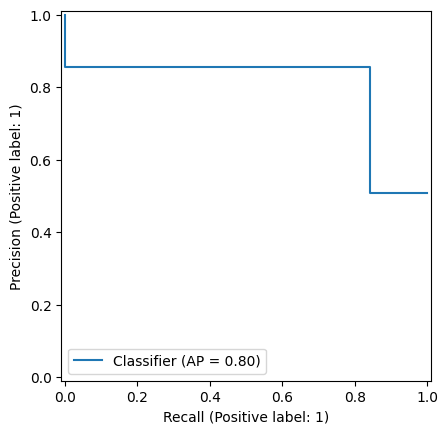

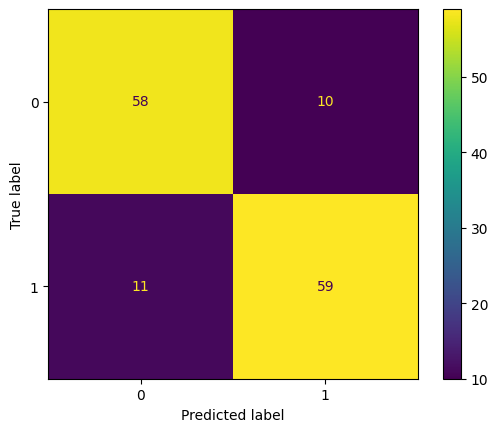

In [52]:
plots = get_performance_plots(y_pred=predictions["model"], y_true=y_test, prefix="dag")

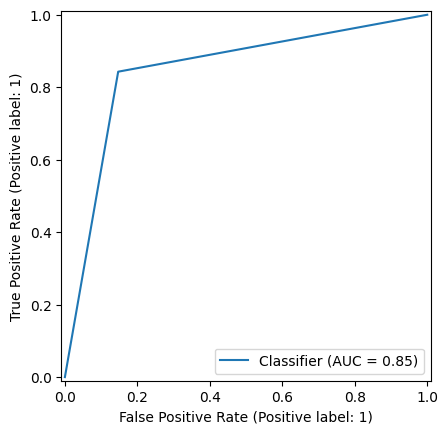

In [58]:
plots["dag_roc_curve"]

In [ ]:
from credit_approval.model.train import train_model
from credit_approval.scoring.score_model import score_model

In [14]:
train_model(config={})

KeyError: 'type'

In [9]:
from credit_approval.data.retrieval import get_data_info
from credit_approval.data.featurization import get_train_test_sets


In [11]:
info = get_data_info()

In [12]:
info

,name,role,type,demographic,description,units,missing_values
0,A16,Target,Categorical,None,None,None,no
1,A15,Feature,Continuous,None,None,None,no
2,A14,Feature,Continuous,None,None,None,yes
3,A13,Feature,Categorical,None,None,None,no
4,A12,Feature,Categorical,None,None,None,no
5,A11,Feature,Continuous,None,None,None,no
6,A10,Feature,Categorical,None,None,None,no
7,A9,Feature,Categorical,None,None,None,no
8,A8,Feature,Continuous,None,None,None,no
9,A7,Feature,Categorical,None,None,None,yes
